# PARAMETER IDENTIFICATION NOTEBOOK

In this notebook we leverage the pretrained surrogate models to identify the generating transmissivity fiels.\
We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

##### Importing necessary libraries

In [1]:
# Standard library imports
import sys

import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import arviz as az
import timeit

import scipy.stats as stats
from keras.models import Sequential
from keras.layers import Dense, Concatenate
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model

#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal
from scipy.stats import uniform


# Local module imports
sys.path.append('./src/SurrogateModeling')
sys.path.append('./src/InverseProblems')
sys.path.append('./src/utils')
from utils import * 
from plotting import *
from random_process import *


2024-07-27 18:42:05.208328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Ray module not found. Multiprocessing features are not available


#### Decide sample to use for experimental data

In [2]:
sample = 77 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_coarse_"+str(sample)

#### Set Bayesian Identification Parameters

In [3]:
# Noise Configuration
noise = 0.001

#### Load Surrogate Models

In [4]:
# Extract test data for visualization or further processing
n_eig = 64
X_values = np.loadtxt('./data/X_test_64000.csv', delimiter = ',')
y_values = np.loadtxt('./data/y_test_64000.csv',delimiter = ',')

In [5]:
model_lf = Sequential()

# Add layers to the model
model_lf.add(Dense(128, input_shape=(64,), activation='gelu'))
model_lf.add(Dense(32, activation='gelu'))
model_lf.add(Dense(25, activation='exponential'))

model_lf = load_model('./models1/model_LF_16000_2.keras')

/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model_hf = Sequential()

model_hf.add(Dense(256, input_shape=(89,), activation='gelu'))
model_hf.add(Dense(128, activation='gelu'))
model_hf.add(Dense(64, activation='gelu'))
model_hf.add(Dense(25, activation='exponential'))

model_hf = load_model('./models1/model_HF_16000_1.keras')

In [7]:
def model_nn (input):
    input = input.reshape(1,64)
    input_fine = np.hstack((input, model_lf(input) )).reshape(1,89)
    return np.array(model_hf(input_fine)).reshape(25)

### Define a custom Uniform random variable class

In [8]:
# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]
# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# Define the prior distribution for the input parameters
# Assuming uniform distributions over specified ranges for each parameter
#x_distribution = CustomUniform(-5*np.ones(64), 5*np.ones(64))
# prior distribution
x_distribution = stats.multivariate_normal(mean = np.zeros(n_eig), cov = np.eye(n_eig))

# Pass the sampled input to the forward model
# set the likelihood
cov_likelihood = noise * np.eye(25)
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood)  

In [9]:
x_true

array([-0.11138733,  0.404416  ,  0.56345712, -0.04529058,  1.11822363,
        0.38436143,  1.55698032, -0.61190066,  0.42151951, -1.00975403,
        1.30685361,  1.2247637 , -0.88985628,  0.34302825,  0.37904138,
       -1.18568594,  0.53925364, -1.14758329,  1.13138835,  0.46606884,
       -1.05927664,  0.77910939,  0.21978361,  1.36874045,  0.21130427,
        0.65777512, -1.67319073,  0.54573967, -0.32618328, -0.22223048,
        1.50365576, -0.01108663,  0.13030104, -0.27026693, -1.56166865,
        0.80520488,  0.53966327, -0.05780435,  1.32804286, -0.28048059,
       -0.05480002, -0.5531175 , -0.01317493,  1.37376094,  0.67667167,
       -0.81026028, -1.448499  ,  1.63137553,  1.08419268, -0.61185457,
        0.10461838, -0.96655551, -0.65993069, -1.25257016, -2.1350219 ,
        0.08517789, -0.78407719, -1.19973194, -0.03026557,  0.3724476 ,
       -0.15134051, -0.11570591, -0.13159769,  0.93692866])

#### Perform least square optimization for each starting point

In [10]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

bounds = (-3*np.ones(n_eig), 3*np.ones(n_eig))

# Iterate over each parameter start point to perform optimizatio
# Perform least squares optimization given the observed data, forward model,
# start point, and parameter bounds
optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_nn , 
        start_point=np.zeros(n_eig), 
        bounds=bounds,
        l2_coeff = 0#1e-6
    )

# Append the optimized parameters to the list of initial guesses
initial_guesses.append(optimized_params)

# Print the optimized parameters for this iteration
print(f"Optimized Params : {optimized_params}")


Real Params:  [-0.11138733  0.404416    0.56345712 -0.04529058  1.11822363  0.38436143
  1.55698032 -0.61190066  0.42151951 -1.00975403  1.30685361  1.2247637
 -0.88985628  0.34302825  0.37904138 -1.18568594  0.53925364 -1.14758329
  1.13138835  0.46606884 -1.05927664  0.77910939  0.21978361  1.36874045
  0.21130427  0.65777512 -1.67319073  0.54573967 -0.32618328 -0.22223048
  1.50365576 -0.01108663  0.13030104 -0.27026693 -1.56166865  0.80520488
  0.53966327 -0.05780435  1.32804286 -0.28048059 -0.05480002 -0.5531175
 -0.01317493  1.37376094  0.67667167 -0.81026028 -1.448499    1.63137553
  1.08419268 -0.61185457  0.10461838 -0.96655551 -0.65993069 -1.25257016
 -2.1350219   0.08517789 -0.78407719 -1.19973194 -0.03026557  0.3724476
 -0.15134051 -0.11570591 -0.13159769  0.93692866]
Optimized Params : [-4.77292429e-01 -7.02956418e-01 -3.81566131e-01  6.42481238e-02
  5.61951418e-01 -2.19272899e-01  1.01991168e+00 -3.92391580e-02
 -6.78152881e-01 -5.78656328e-01  1.11424217e+00  1.07053997

#### Do Metropolis Hastings Sampling

Set the parameters for the algorithm 

In [11]:
scaling = 0.15
n_iter = 55000
burnin = 5000
thin = 50

In [12]:
#cov = np.diag(np.linspace(1,5,n_eig))
cov = np.eye(n_eig)

In [13]:
# initialise the LinkFactory
my_posterior = tda.Posterior(x_distribution, y_distribution, model_nn)
# random walk Metropolis
#my_proposal = tda.GaussianRandomWalk(C=covariance_matrix*1e-19, scaling= scaling)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)
#my_proposal = tda.AdaptiveMetropolis(C0=np.eye(n_eig), sd = 0.2)


In [14]:
# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []
ESS_values = []

# Iterate over each initial guess to set up and run the Markov chain sampler
start_0 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posterior, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=initial_guess)
    idata = tda.to_inference_data(samples, level='fine')
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
    # Append the samples to the list
    samples_mh.append(idata)
    ess = az.ess(idata)
    # Compute and print the Effective Sample Size (ESS) of the first set of samples
    print("Effective Sample Size: ", ess,"\n\n\n")
end_0 = timeit.default_timer() 

# Computing diagnostics and collecting results
#print("\nRhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')))

#print('Mean ESS:' , np.mean(ESS_values, axis = 0))
#print('Time/ESS MDA',(end_0-start_0)/(5*np.mean(ESS_values, axis = 0)) )


Sampling chain 1/1


Running chain, α = 0.40: 100%|██████████| 55000/55000 [05:04<00:00, 180.79it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 104.4
    x1       float64 8B 99.42
    x2       float64 8B 98.19
    x3       float64 8B 166.1
    x4       float64 8B 80.58
    x5       float64 8B 114.3
    ...       ...
    x58      float64 8B 96.66
    x59      float64 8B 88.78
    x60      float64 8B 86.16
    x61      float64 8B 83.55
    x62      float64 8B 115.7
    x63      float64 8B 92.59 





Let's look at the trace plot of one chain

# Diagnostics 

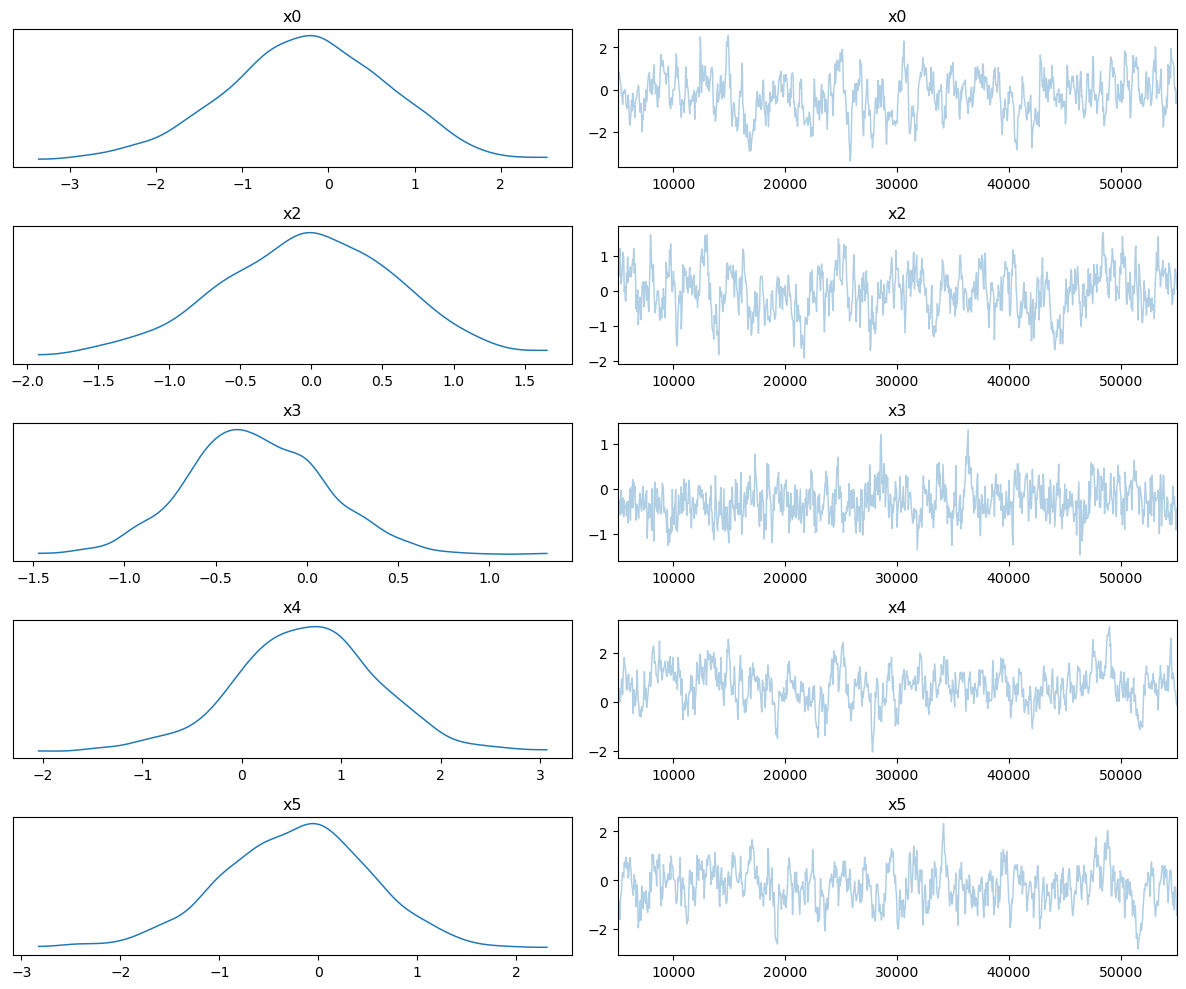

In [15]:
# Plot trace of the first set of samples
az.plot_trace(idata, var_names=['x0', 'x2', 'x3','x4','x5'])
plt.tight_layout()
plt.show()


Let's compare the prediction of the mean parameter combination and the experimental signal

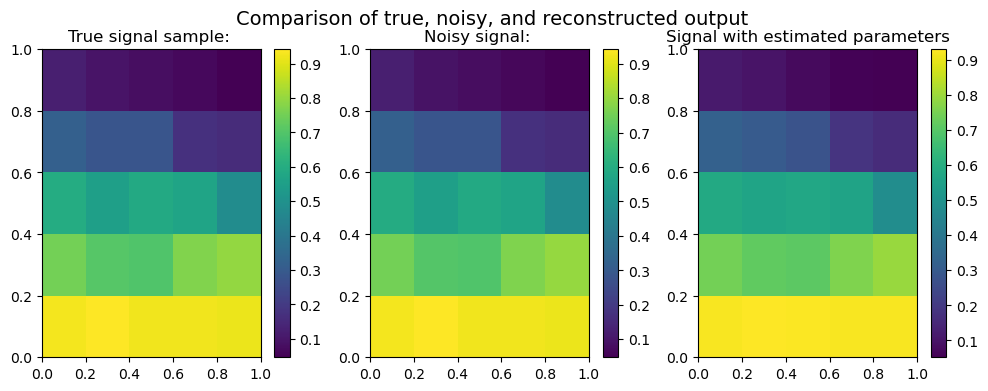

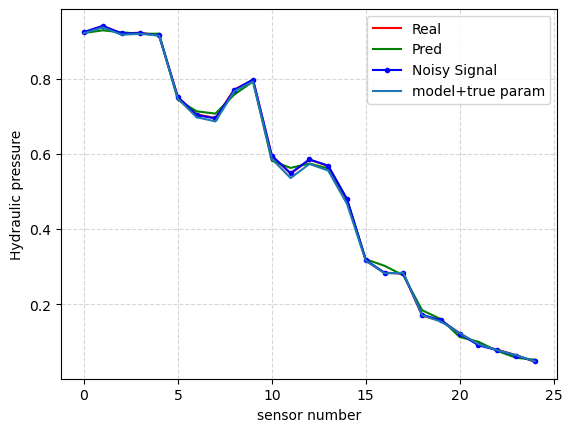

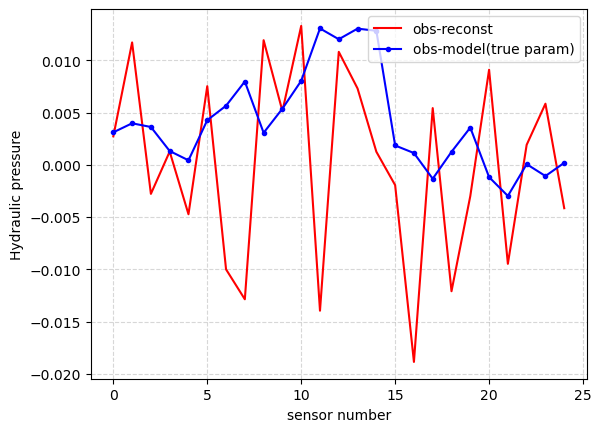

In [16]:
# Plotting and data collection
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_results( y_true, y_observed, model_nn, data, n_eig,x_true)

Finally, let's look at the parameters distribution

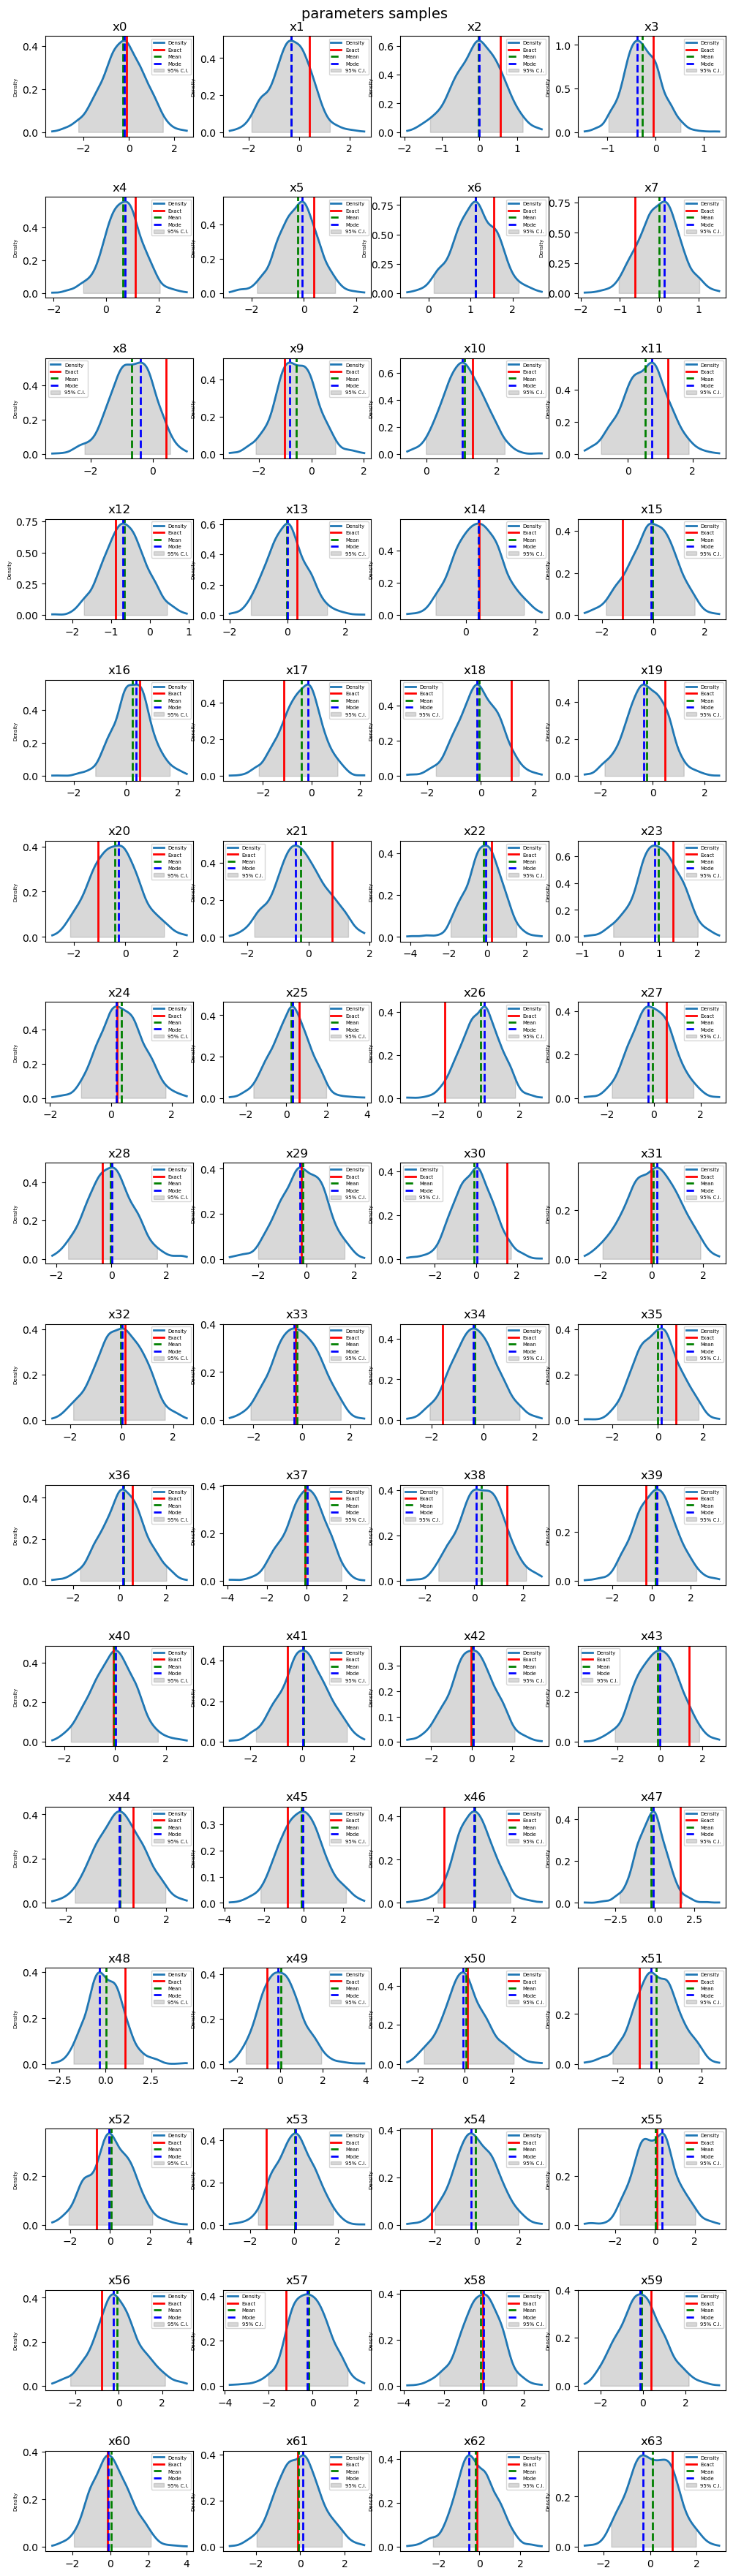

In [17]:
keys = ['x'+ str(i) for i in range(64)]
plot_parameter_distributions(data, x_true, keys, n_eig) 

### Reconstructed field 

<Figure size 1000x400 with 0 Axes>

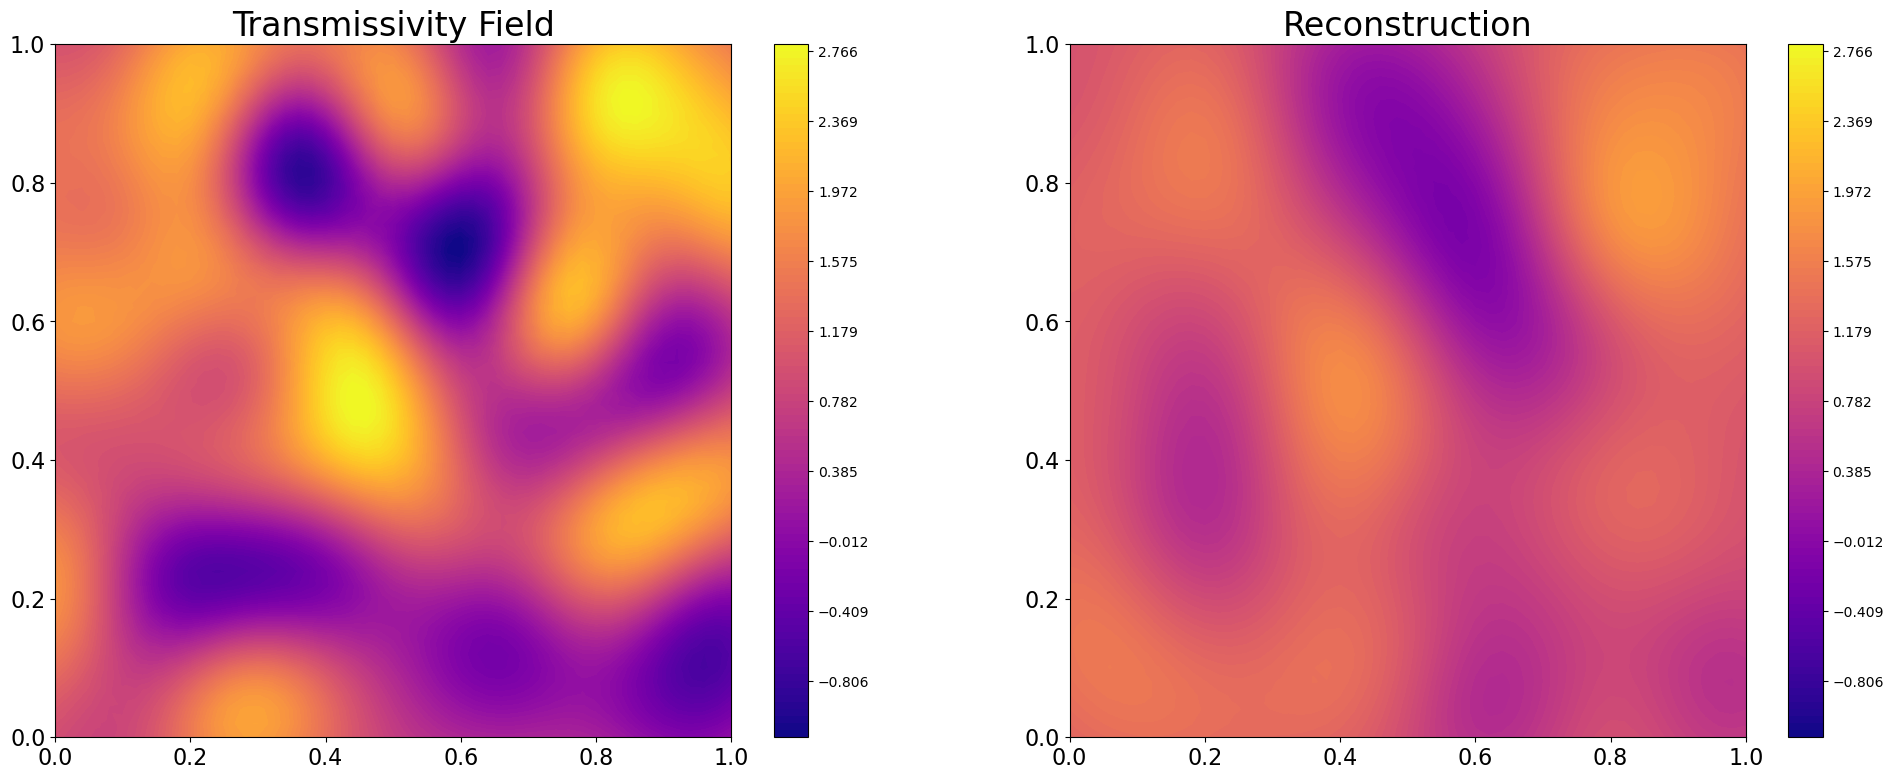

In [18]:
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False)

# DIFFERENT PARAMETERS 

### Lower likelyhood

In [22]:
noise = 0.001
scaling = 0.05
n_iter = 55000
burnin = 5000
thin = 50


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = noise * np.eye(25)
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood*0.1)  

# initialise the LinkFactory
my_posterior = tda.Posterior(x_distribution, y_distribution, model_nn)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posterior, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64))
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")




Sampling chain 1/1


Running chain, α = 0.25: 100%|██████████| 55000/55000 [05:07<00:00, 178.87it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 14.3
    x1       float64 8B 16.11
    x2       float64 8B 20.58
    x3       float64 8B 4.182
    x4       float64 8B 5.109
    x5       float64 8B 7.831
    ...       ...
    x58      float64 8B 17.6
    x59      float64 8B 20.12
    x60      float64 8B 7.815
    x61      float64 8B 9.128
    x62      float64 8B 5.059
    x63      float64 8B 9.461 





<Figure size 1000x400 with 0 Axes>

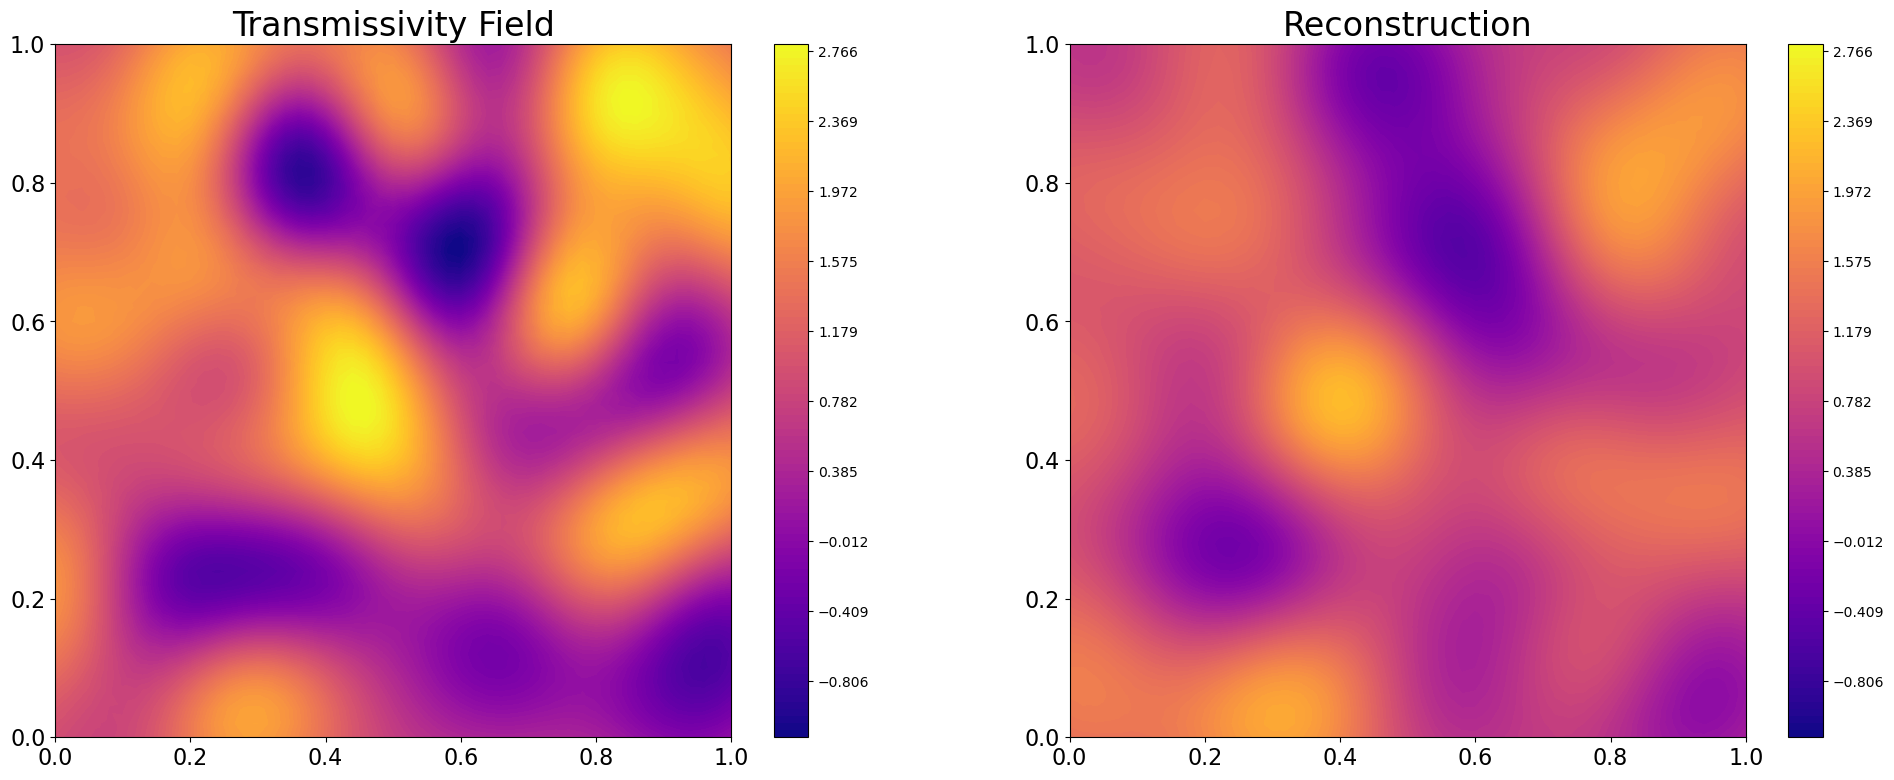

In [23]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False) 

### Higher Noise 

In [19]:
noise = 0.01
scaling = 0.05
n_iter = 55000
burnin = 5000
thin = 50


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = noise**2 * np.eye(25)
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood)  

# initialise the LinkFactory
my_posterior = tda.Posterior(x_distribution, y_distribution, model_nn)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posterior, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64))
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")

Sampling chain 1/1


Running chain, α = 1.00:   0%|          | 0/55000 [00:00<?, ?it/s]

Running chain, α = 0.32: 100%|██████████| 55000/55000 [05:14<00:00, 174.65it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 1.537
    x1       float64 8B 38.0
    x2       float64 8B 38.71
    x3       float64 8B 20.67
    x4       float64 8B 3.428
    x5       float64 8B 3.584
    ...       ...
    x58      float64 8B 10.64
    x59      float64 8B 16.18
    x60      float64 8B 22.52
    x61      float64 8B 9.974
    x62      float64 8B 15.87
    x63      float64 8B 7.052 





In [20]:
e = [ess.data_vars['x'+str(i)].values for i in range(64)]
np.mean(e)

18.82572894456068

<Figure size 1000x400 with 0 Axes>

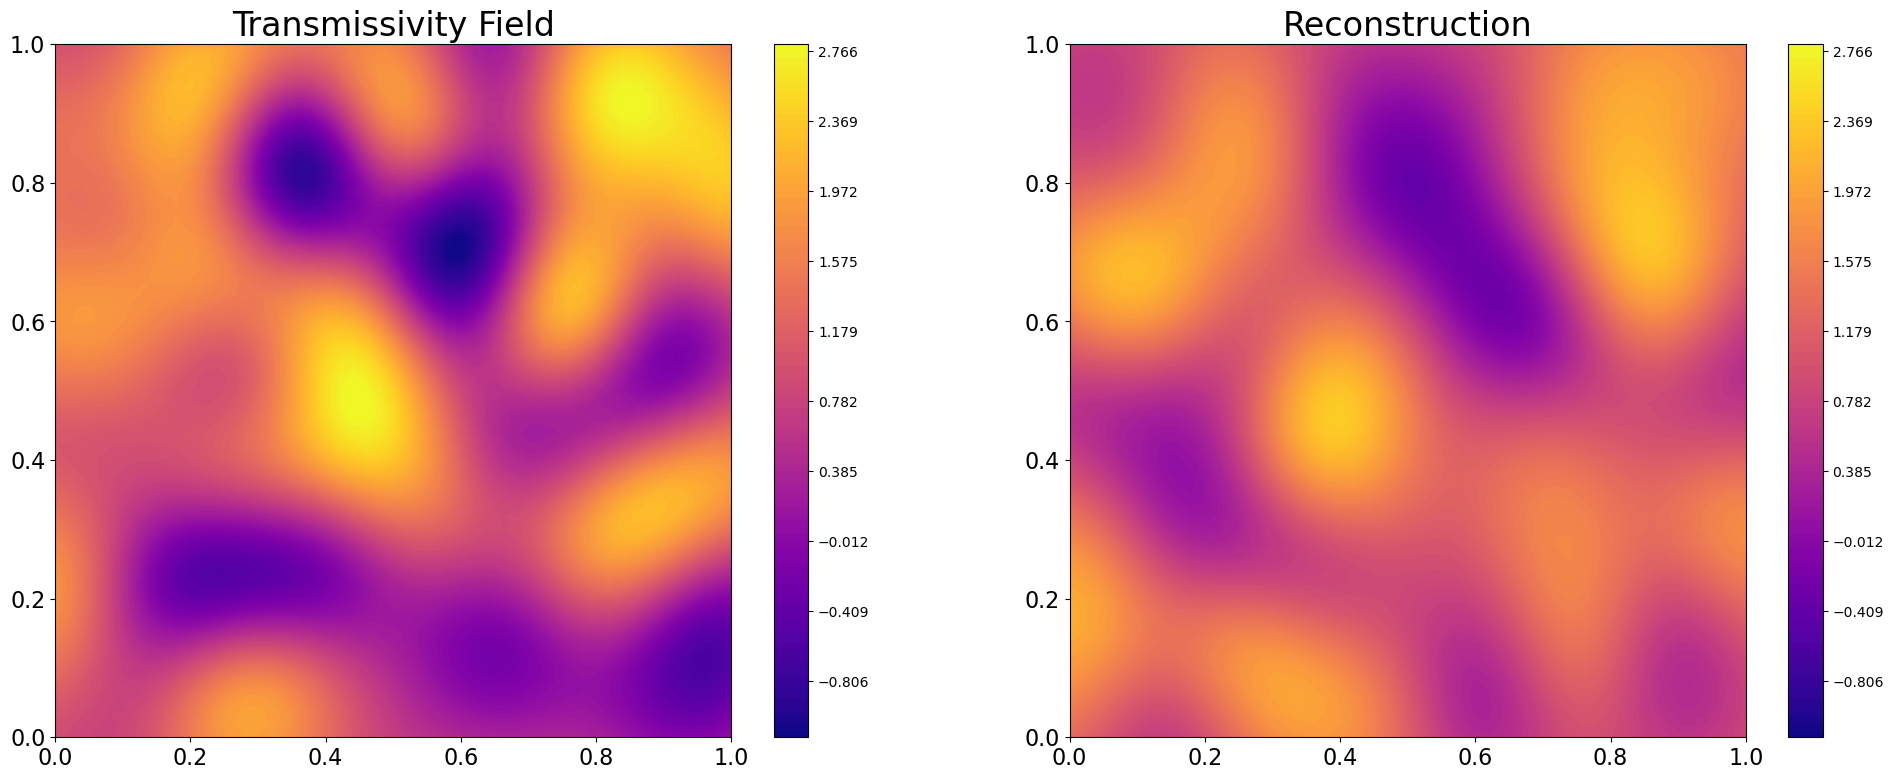

In [21]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False) 

### No noise 

In [47]:
noise = 0.0
scaling = 0.05
n_iter = 55000
burnin = 5000
thin = 50


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = 0.01**2 * np.eye(25)
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood)  

# initialise the LinkFactory
my_posterior = tda.Posterior(x_distribution, y_distribution, model_nn)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posterior, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64))
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")

Sampling chain 1/1


Running chain, α = 0.25: 100%|██████████| 55000/55000 [05:35<00:00, 163.74it/s]


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 15.62
    x1       float64 8B 5.568
    x2       float64 8B 9.743
    x3       float64 8B 3.501
    x4       float64 8B 1.971
    x5       float64 8B 2.247
    ...       ...
    x58      float64 8B 10.77
    x59      float64 8B 24.75
    x60      float64 8B 8.458
    x61      float64 8B 1.992
    x62      float64 8B 1.819
    x63      float64 8B 7.932 





/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


<Figure size 1000x400 with 0 Axes>

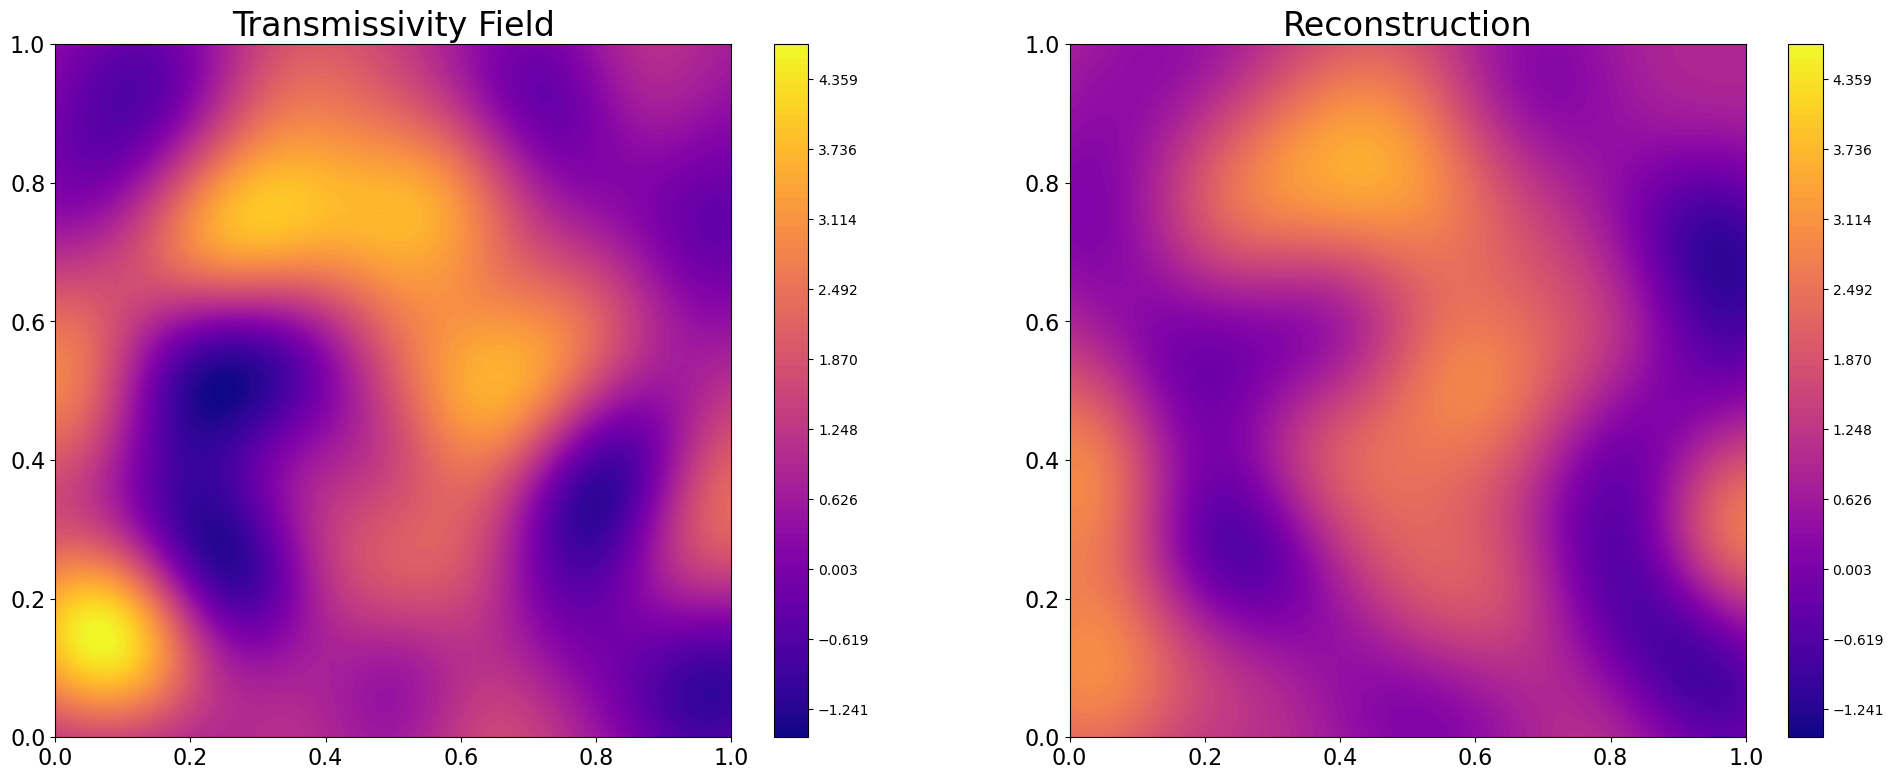

In [48]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False) 

### True likelyhood

In [24]:
noise = 0.001
scaling = 0.0075
n_iter = 55000
burnin = 5000
thin = 50


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = noise**2 * np.eye(25)
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood)  

# initialise the LinkFactory
my_posterior = tda.Posterior(x_distribution, y_distribution, model_nn)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posterior, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64))
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")

Sampling chain 1/1


Running chain, α = 0.22: 100%|██████████| 55000/55000 [05:43<00:00, 160.20it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 6.574
    x1       float64 8B 6.031
    x2       float64 8B 6.333
    x3       float64 8B 2.37
    x4       float64 8B 1.33
    x5       float64 8B 1.906
    ...       ...
    x58      float64 8B 10.71
    x59      float64 8B 5.253
    x60      float64 8B 1.396
    x61      float64 8B 17.67
    x62      float64 8B 1.317
    x63      float64 8B 8.561 





<Figure size 1000x400 with 0 Axes>

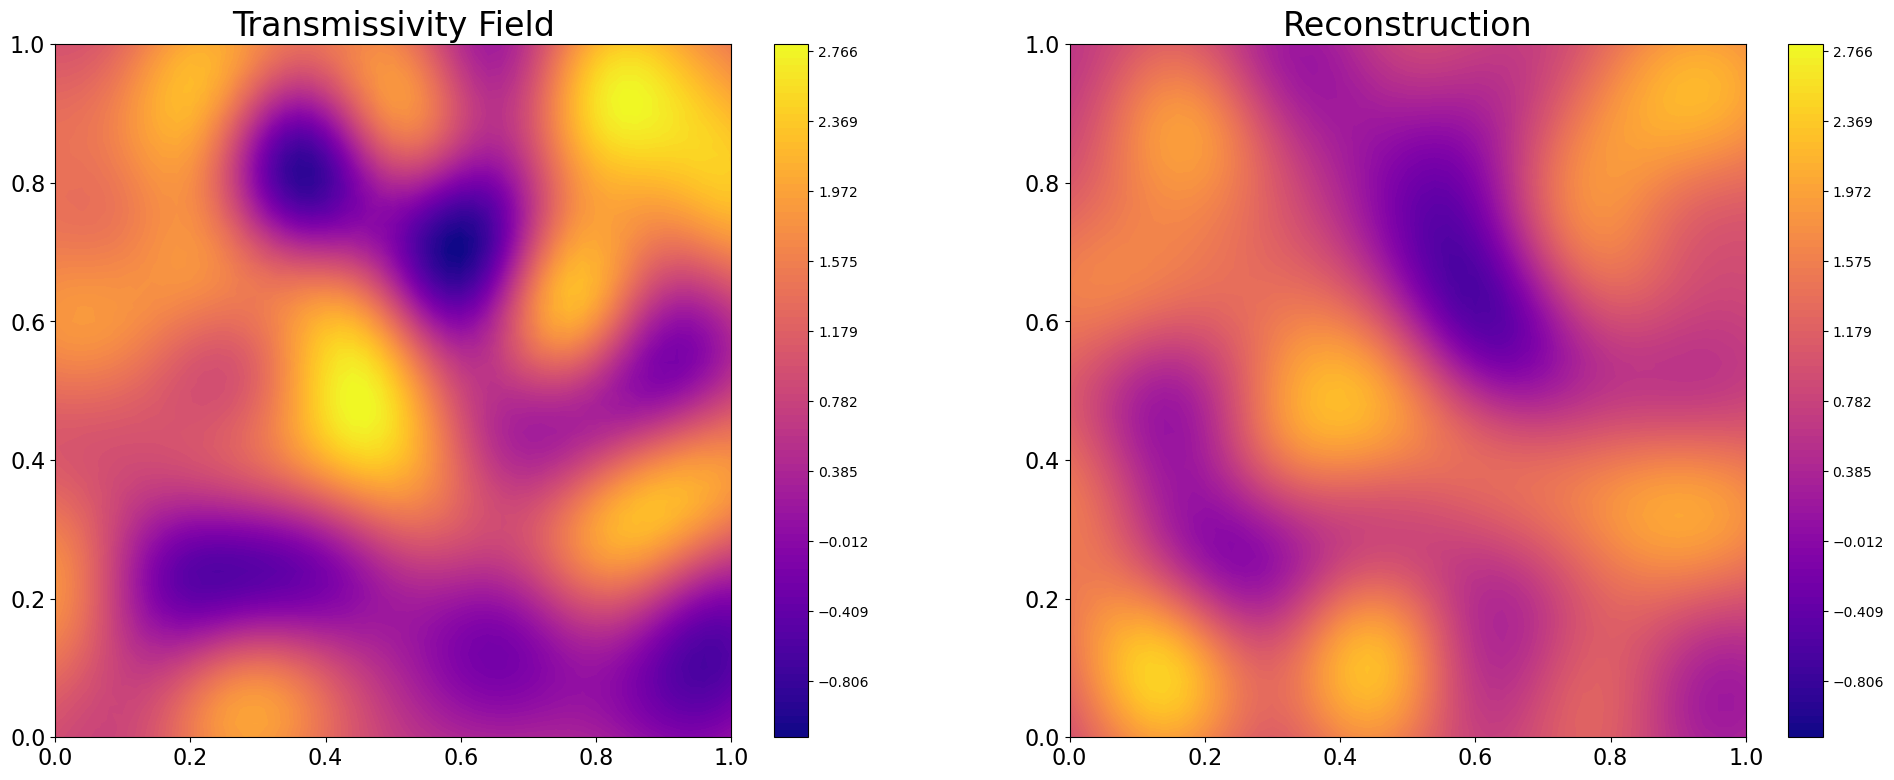

In [25]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False) 

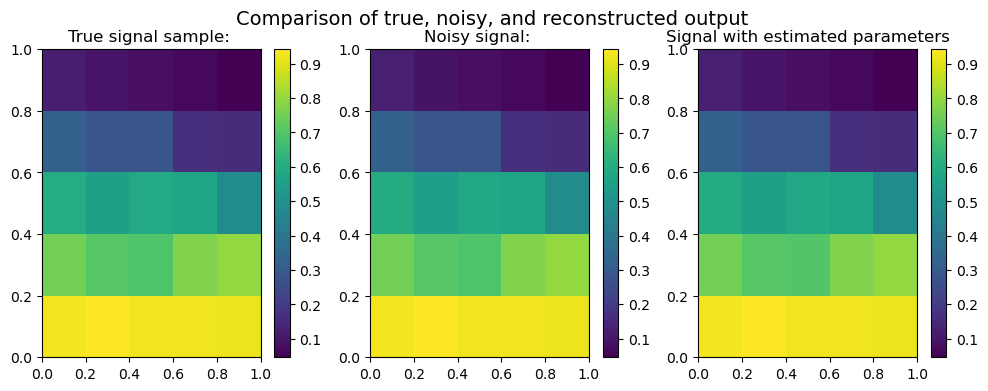

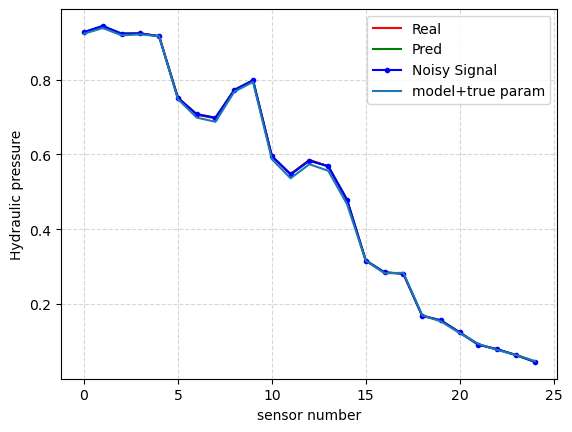

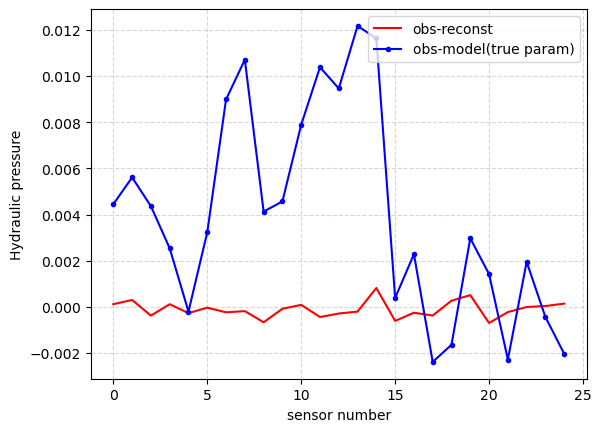

In [26]:
# Plotting and data collection
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_results( y_true, y_observed, model_nn, data, n_eig,x_true)

### Computing Time/ ESS

In [12]:
noise = 0.01
scaling = 0.05
n_iter = 55000
burnin = 5000
thin = 50


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = noise**2 * np.eye(25)
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood)  

# initialise the LinkFactory
my_posterior = tda.Posterior(x_distribution, y_distribution, model_nn)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

ESS_values = []
times = []
# RUN THE MCMC
for i in range(3): 
    start = timeit.default_timer()
    samples = tda.sample(my_posterior, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64))
    end = timeit.default_timer()
    idata = tda.to_inference_data(samples, level='fine')
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
    # Save executing time 
    times.append(end-start)
    ess = az.ess(idata)  
    e = [ess.data_vars['x'+str(i)].values for i in range(64)]
    ESS_values.append(np.mean(e))
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ESS_values)
print("Computing times:       ", times )
print("Average Time/ESS       ", np.mean(times)/np.mean(ESS_values))

Sampling chain 1/1


Running chain, α = 0.27: 100%|██████████| 55000/55000 [05:39<00:00, 162.12it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α = 0.27: 100%|██████████| 55000/55000 [05:33<00:00, 164.79it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α = 0.22: 100%|██████████| 55000/55000 [07:08<00:00, 128.31it/s] 
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  [13.487462657818607, 15.0448218839643, 12.885246741098396]
Computing times:        [339.30775495800026, 333.7544202089998, 343.797578834]
Average Time/ESS        24.55143323381248


In [13]:
import numpy as np

In [15]:
np.mean([339.30775495800026, 333.7544202089998, 343.797578834])

338.9532513336667